<a href="https://colab.research.google.com/github/talhaanwarch/ISIC2K19/blob/master/ISIC2k19_inceptionresnetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#data download

In [1]:
!wget https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_Input.zip

--2020-04-29 01:44:56--  https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_Input.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.133.61
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.133.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9771618190 (9.1G) [application/zip]
Saving to: ‘ISIC_2019_Training_Input.zip’

ISIC_2019_Training_ 100%[===================>]   9.10G  36.3MB/s    in 3m 54s  

2020-04-29 01:48:51 (39.9 MB/s) - ‘ISIC_2019_Training_Input.zip’ saved [9771618190/9771618190]



In [0]:
%%capture
!unzip ISIC_2019_Training_Input.zip;

In [0]:
rm ISIC_2019_Training_Input.zip

In [4]:
!wget https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Test_Input.zip

--2020-04-29 01:53:48--  https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Test_Input.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.129.181
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.129.181|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3823247963 (3.6G) [application/zip]
Saving to: ‘ISIC_2019_Test_Input.zip’

ISIC_2019_Test_Inpu 100%[===================>]   3.56G  45.1MB/s    in 89s     

2020-04-29 01:55:18 (40.8 MB/s) - ‘ISIC_2019_Test_Input.zip’ saved [3823247963/3823247963]



In [0]:
%%capture
!unzip ISIC_2019_Test_Input.zip;

In [0]:
rm ISIC_2019_Test_Input.zip

In [1]:
import pandas as pd
train_df=pd.read_csv('https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_GroundTruth.csv')
train_df.drop('UNK',inplace=True,axis=1)
train_df['image']=train_df['image']+'.jpg'
train_df.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC
0,ISIC_0000000.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
test_df=pd.read_csv('https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Test_Metadata.csv')
test_df['image']=test_df['image']+'.jpg'
test_df.head()

,image,age_approx,anatom_site_general,sex
0,ISIC_0034321.jpg,60.0,NaN,female
1,ISIC_0034322.jpg,70.0,anterior torso,male
2,ISIC_0034323.jpg,70.0,lower extremity,male
3,ISIC_0034324.jpg,70.0,lower extremity,male
4,ISIC_0034325.jpg,30.0,upper extremity,female


In [3]:
import cv2
img=cv2.imread('ISIC_2019_Test_Input/ISIC_0073120.jpg')
img.shape

(1024, 1024, 3)

#Model download

In [0]:
%%capture
!pip install image-classifiers==1.0.0b1

In [5]:
from classification_models.keras import Classifiers
inceptionresnetv2, preprocess_input = Classifiers.get('inceptionresnetv2')

Using TensorFlow backend.


In [0]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train_df, test_size = 0.2)

In [0]:
from keras_preprocessing.image import ImageDataGenerator

train_data_gen= ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=.2,
    rescale=1/255,
    fill_mode='nearest',
    shear_range=0.2,
    brightness_range=[0.5, 1.5])

In [8]:
img_shape=300
batch_size=20
col=train_df.columns[1::].to_list()
col

['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']

In [9]:
train_generator=train_data_gen.flow_from_dataframe(train,directory='/content/ISIC_2019_Training_Input',
                                                      target_size=(img_shape,img_shape),
                                                      x_col="image",
                                                      y_col=col,
                                                      class_mode='raw',
                                                      shuffle=False,
                                                      batch_size=batch_size)

val_generator=train_data_gen.flow_from_dataframe(val,directory='/content/ISIC_2019_Training_Input',
                                                      target_size=(img_shape,img_shape),
                                                      x_col="image",
                                                      y_col=col,
                                                      class_mode='raw',
                                                      shuffle=False,
                                                      batch_size=batch_size)
test_generator=train_data_gen.flow_from_dataframe(test_df,directory='/content/ISIC_2019_Test_Input',
                                                      target_size=(img_shape,img_shape),
                                                      x_col="image",
                                                      class_mode=None,
                                                      shuffle=False,
                                                      batch_size=batch_size)

Found 20264 validated image filenames.
Found 5067 validated image filenames.
Found 8238 validated image filenames.


In [10]:
base_model = inceptionresnetv2(input_shape=(img_shape,img_shape,3), weights='imagenet', include_top=False)
train_generator.next()[0].shape,train_generator.next()[1].shape


219062272/219055592 [==============================] - 5s 0us/step


((20, 300, 300, 3), (20, 8))

In [0]:
import keras


x = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(len(col), activation='sigmoid')(x)
model = keras.models.Model(inputs=[base_model.input], outputs=[output])


model.compile(keras.optimizers.rmsprop(lr=0.0001, decay=1e-6),loss="binary_crossentropy",metrics=["accuracy"])


from sklearn.metrics import accuracy_score,f1_score,roc_auc_score
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

In [12]:

results = model.fit_generator(train_generator,epochs=20,
                              steps_per_epoch=train_generator.n/batch_size,
                              validation_data=val_generator,
                             validation_steps=val_generator.n/batch_size,
                              callbacks=[
                                  ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)])

Epoch 1/20
1014/1013 [==============================] - 1245s 1s/step - loss: 0.1870 - accuracy: 0.9269 - val_loss: 0.1484 - val_accuracy: 0.9319
Epoch 2/20
1014/1013 [==============================] - 1167s 1s/step - loss: 0.1521 - accuracy: 0.9393 - val_loss: 0.0728 - val_accuracy: 0.9367
Epoch 3/20
1014/1013 [==============================] - 1189s 1s/step - loss: 0.1368 - accuracy: 0.9451 - val_loss: 0.1304 - val_accuracy: 0.9399
Epoch 4/20
1014/1013 [==============================] - 1198s 1s/step - loss: 0.1269 - accuracy: 0.9498 - val_loss: 0.0569 - val_accuracy: 0.9427
Epoch 5/20
1014/1013 [==============================] - 1201s 1s/step - loss: 0.1196 - accuracy: 0.9535 - val_loss: 0.1325 - val_accuracy: 0.9452
Epoch 6/20
1014/1013 [==============================] - 1199s 1s/step - loss: 0.1121 - accuracy: 0.9563 - val_loss: 0.0934 - val_accuracy: 0.9467
Epoch 7/20
1014/1013 [==============================] - 1177s 1s/step - loss: 0.1059 - accuracy: 0.9590 - val_loss: 0.0491 -

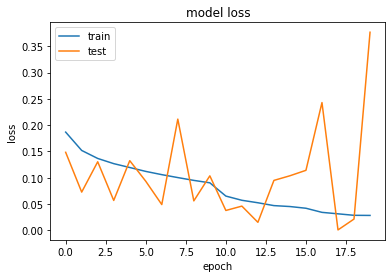

In [13]:
import matplotlib.pyplot as plt

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
y_pred = model.predict_generator(val_generator,steps=val_generator.n/batch_size)
y_pred=y_pred.round().astype(int)
y_true=val.iloc[:,1::].values
print(accuracy_score(y_true,y_pred))
print(f1_score(y_true,y_pred,average='macro'))


0.7985000986777185
0.7661361539656808


In [0]:
y_test = model.predict_generator(test_generator,steps=test_generator.n/batch_size)
#y_test=y_test.round().astype(int)

In [16]:
import numpy as np
d = pd.DataFrame(0, index=np.arange(len(y_test)), columns=col)
sub=pd.concat([test_df['image'],d],axis=1)
sub['image']=sub['image'].str.replace(r'.jpg', '')
sub.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC
0,ISIC_0034321,0,0,0,0,0,0,0,0
1,ISIC_0034322,0,0,0,0,0,0,0,0
2,ISIC_0034323,0,0,0,0,0,0,0,0
3,ISIC_0034324,0,0,0,0,0,0,0,0
4,ISIC_0034325,0,0,0,0,0,0,0,0


In [17]:
for i,j in enumerate(col):
    sub[j]=y_test[:,i]
sub.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC
0,ISIC_0034321,2.411615e-03,9.950216e-03,9.951366e-01,1.865926e-06,1.149814e-03,5.015582e-07,1.408054e-07,2.692782e-05
1,ISIC_0034322,1.339413e-10,9.999999e-01,2.802629e-18,1.268978e-24,2.317892e-11,3.138214e-30,4.118626e-30,5.309550e-28
2,ISIC_0034323,4.133657e-07,1.456745e-07,9.999576e-01,2.059041e-07,4.149686e-07,1.425497e-11,5.634845e-15,2.874657e-04
3,ISIC_0034324,3.775400e-07,9.999977e-01,1.218146e-12,2.038537e-19,5.121590e-11,4.035054e-22,8.844212e-16,7.612656e-22
4,ISIC_0034325,8.950728e-10,9.999996e-01,1.957036e-14,2.389760e-23,2.163081e-12,3.957146e-29,1.102805e-25,2.668486e-28


In [0]:
sub.to_csv('inceptionresnetv2.csv', index=False)